# Оценка качества моделей регрессии

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date

In [3]:
import datetime

In [4]:
from sklearn.linear_model import Ridge

In [5]:
from tqdm import tqdm_notebook

In [6]:
%matplotlib inline

In [7]:
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 300

In [8]:
df = pd.read_table('./data.tsv')
df.date = pd.to_datetime(df.date, dayfirst=True)
df.weight[:] = [float(a.replace(',', '.')) for a in df.weight]

In [10]:
df.head()

,date,weight
0,2019-01-02,79.4
1,2019-01-04,79.8
2,2019-01-13,79.5
3,2019-01-17,79.8
4,2019-01-19,79.3


In [11]:
df['datePOSIX'] = [d.timestamp() for d in df.date]
min_date = df['datePOSIX'].min()
df['datePOSIX'] = df['datePOSIX']-min_date

In [12]:
df.head()

,date,weight,datePOSIX
0,2019-01-02,79.4,0.0
1,2019-01-04,79.8,172800.0
2,2019-01-13,79.5,950400.0
3,2019-01-17,79.8,1296000.0
4,2019-01-19,79.3,1468800.0


In [17]:
df.tail()

,date,weight,datePOSIX
170,2019-10-25,75.8,25574400.0
171,2019-10-26,76.6,25660800.0
172,2019-10-27,76.8,25747200.0
173,2019-10-28,76.2,25833600.0
174,2019-10-29,76.4,25920000.0


In [13]:
df.shape

(175, 3)

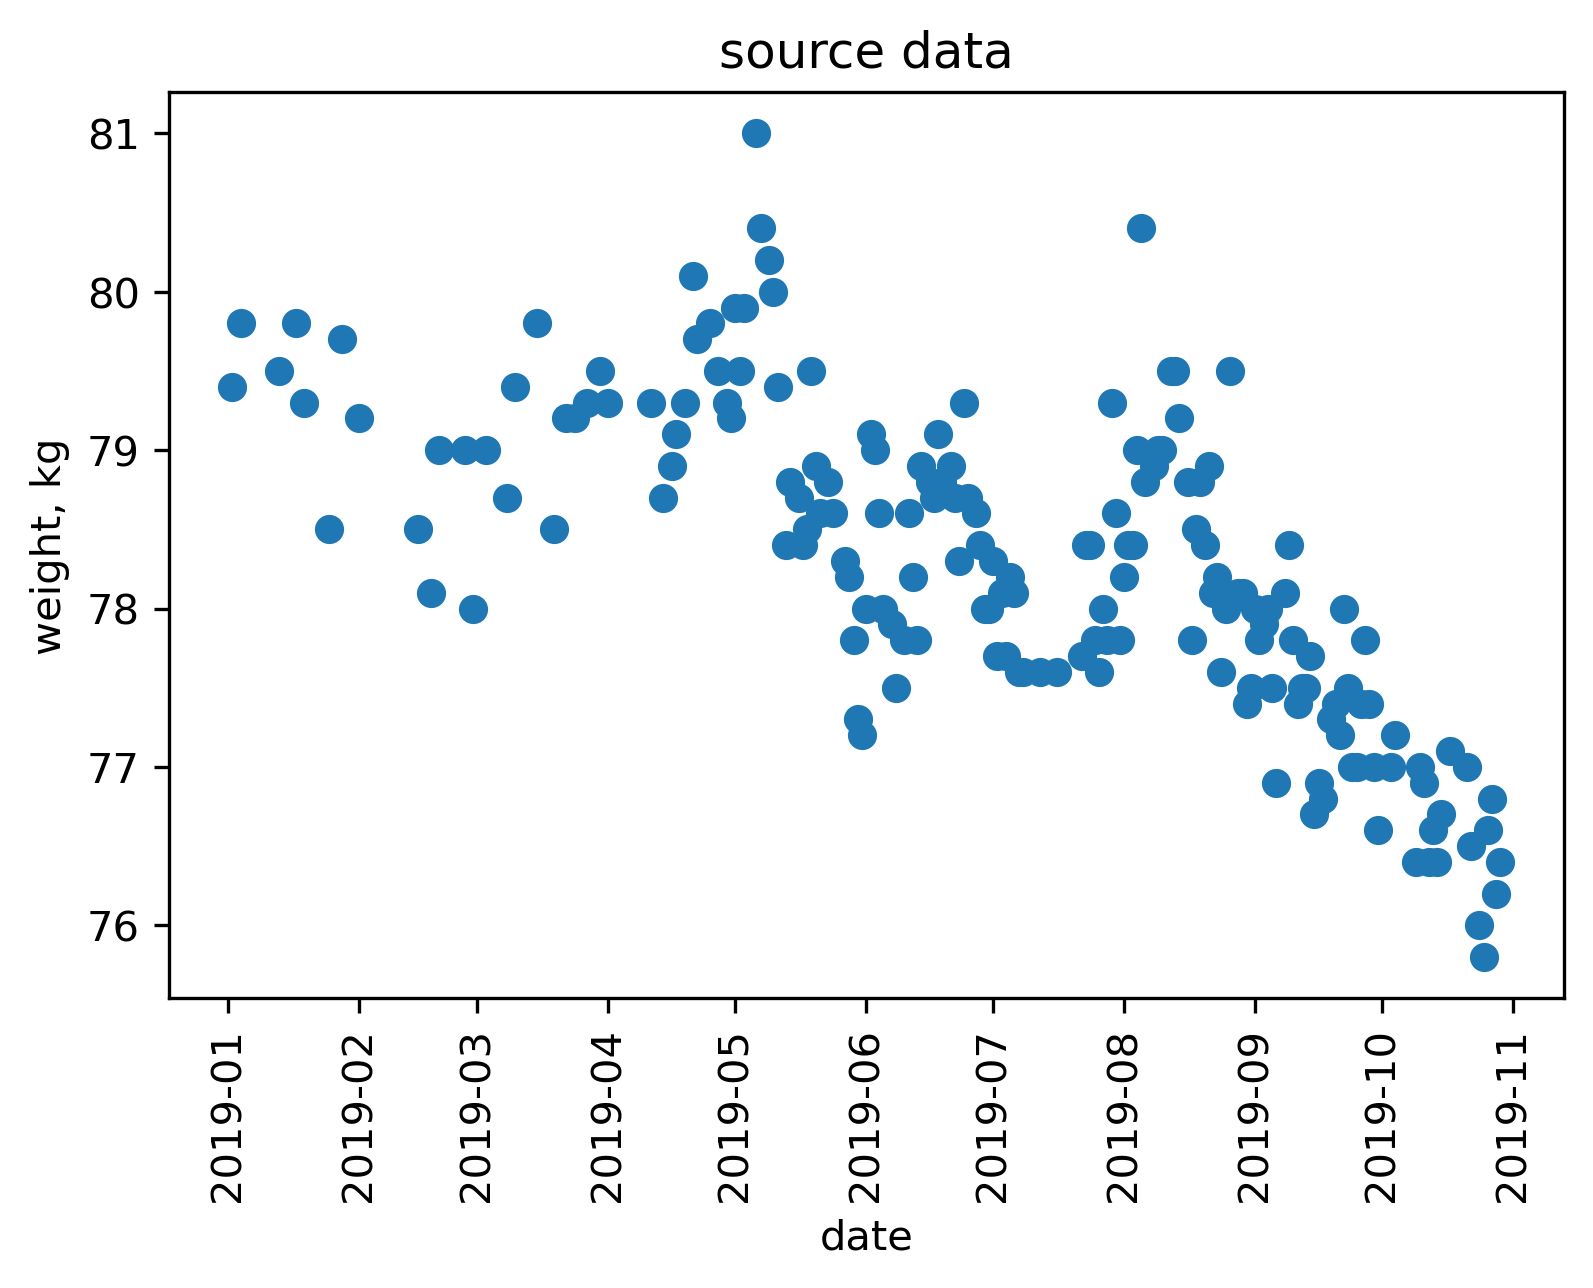

In [14]:
_ = plt.scatter(df.date, df.weight)
_ = plt.title('source data')
_ = plt.xlabel('date')
_ = plt.ylabel('weight, kg')
_ = plt.xticks(rotation=90)

##  Решение линейной регрессии в матричном виде

Ранее было продемонстрировано, что решение задачи линейной регрессии методом максимального правдоподобия эквивалентно решению оптимизационной задачи для функции среднеквадратического отклонения (записано для $n$-мерного случая, $N$ - число экземпляров в обучающей выборке):

$$
x_i = (x_{i}^{(0)}, x_{i}^{(1)}, \dots, x_{i}^{(n)})
$$

$$
\theta = (\theta^{(0)}, \theta^{(1)}, \dots, \theta^{(n)})
$$

$$
\theta^* = \underset{\Theta}{\mathrm{argmin}} \sum_{i=1}^{N}{\left( y_i-\theta\cdot x_i \right)^2}
$$

Для записи в матричном виде введем т.н. матрицу объекты-признаки:

$$
X = \begin{bmatrix}
x_{0}^{(0)} & x_{0}^{(1)} & \dots & x_{0}^{(n)} \\
x_{1}^{(0)} & x_{1}^{(1)} & \dots & x_{1}^{(n)} \\
\dots \\
x_{N}^{(0)} & x_{N}^{(1)} & \dots & x_{N}^{(n)}
\end{bmatrix}
$$

При этом не забываем, что нулевая компонента векторов описания всех объектов - единица.

Кроме этого введем вектор-столбец целевой переменной:
$$
Y = \begin{bmatrix}
y_{0}\\
y_{1}\\
\dots \\
y_{N}
\end{bmatrix}
$$


При этом важно, что $\theta$ - также вектор-столбец

Тогда функция ошибки может быть записана следующим образом:

$$
\mathscr{L}(\theta, X, Y) = \left(Y-X\cdot\theta\right)^T\cdot(Y-X\cdot\theta) = \\
{Y^T}{Y}-2\theta^T{X^T}{Y}+\theta^T{X^T}{X}{\theta}
$$

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = -2{X^T}{Y} + 2{X^T}X\theta
$$

Поскольку функция ошибка квадратична по $\theta$, можно утверждать, что у нее есть экстремум и он глобальный. Положение этого экстремума можно найти обычным образом:

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = 0
$$

Отсюда (можно воспользоваться [Matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)):

$$
2{X^T}X\theta^* = 2{X^T}{Y}
$$

$$
\theta^* = (X^T X)^{-1} X^T Y \tag{1} \label{eq:special}
$$

Осталось проверить, не максимум ли это. Для этого проверяем, что матрица вторых производных (по $\theta$) положительно определена:

$$
\frac{\partial^2 {\mathscr{L}(\theta, X, Y)}}{\partial\theta^2} = 2 X^T X
$$

In [15]:
x_lin_test = np.linspace(df.datePOSIX.min(), df.datePOSIX.max(), 100)

In [16]:
x_lin_test_datetimes = [pd.Timestamp(dt+min_date, unit='s') for dt in x_lin_test]

## Решаем вручную (см. матричный вывод выше)
### создаем матрицу объекты-признаки

In [18]:
X = np.asarray(df.datePOSIX).reshape((-1, 1))
X.shape

(175, 1)

In [19]:
X_0 = np.ones_like(X)

In [20]:
X = np.concatenate([X_0, X], axis=1)
X.shape

(175, 2)

### записываем матрицу (вектор-столбец) целевой переменной

In [21]:
Y = np.asarray(df.weight)[:,np.newaxis]
Y.shape

(175, 1)

### вычисляем $\theta^*$ по формуле (1)

In [22]:
m1 = np.dot(X.T, X)

In [23]:
m2 = np.linalg.inv(m1)

In [24]:
m3 = np.dot(m2, X.T)

In [25]:
theta_star = np.dot(m3, Y)

In [26]:
theta_star

array([[ 8.00277992e+01],
       [-1.10497872e-07]])

### аппроксимируем значения $y$ для всех значений `x_lin_test`
Для этого приводим `x_lin_test` к такому же формату, что и `X`: добавляем нулевую колонку, в которой записаны единицы

In [28]:
X_test = np.asarray(x_lin_test).reshape((-1, 1))
X_test_0 = np.ones_like(X_test)
X_test = np.concatenate([X_test_0, X_test], axis=1)
X_test.shape

(100, 2)

In [29]:
y_test_approximated = np.dot(X_test, theta_star)

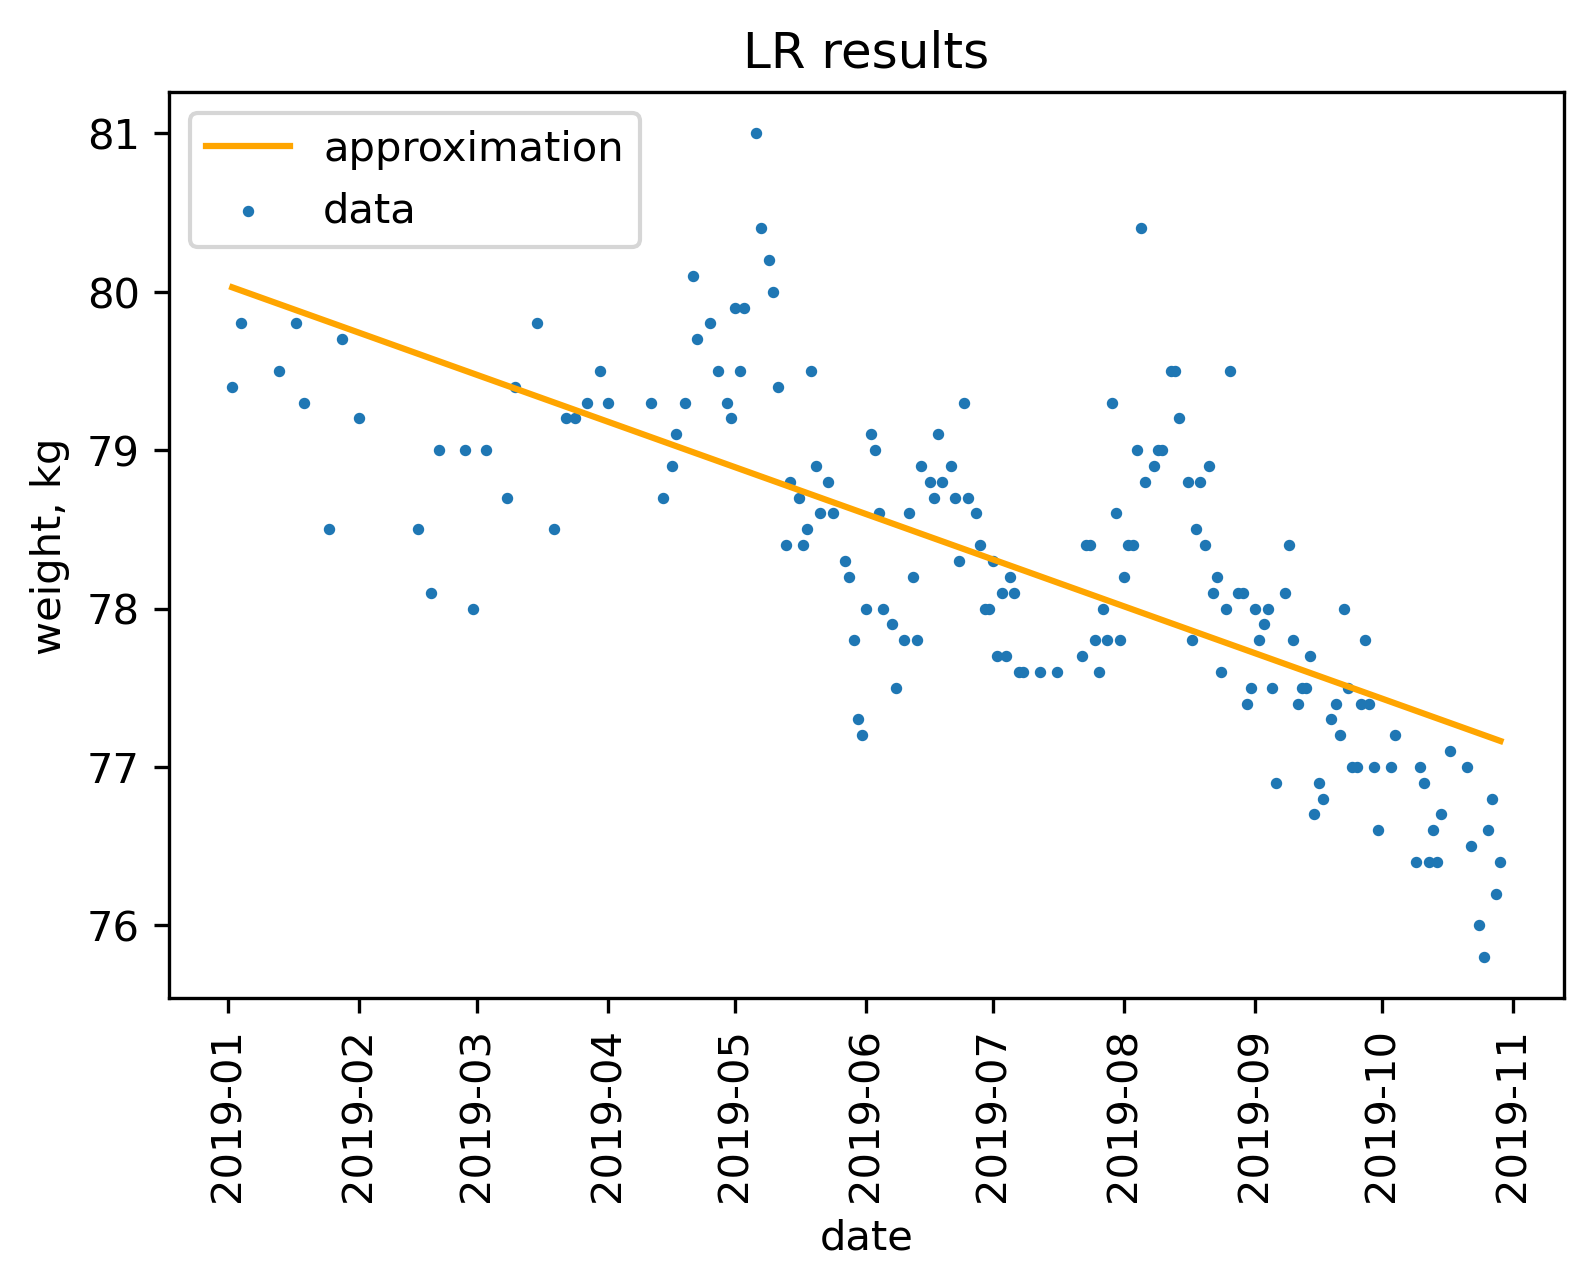

In [30]:
_ = plt.scatter(df.date, df.weight, s = 3, label='data')
_ = plt.plot(x_lin_test_datetimes, y_test_approximated, color='orange', label='approximation')
_ = plt.xticks(rotation=90)
_ = plt.legend()
_ = plt.title('LR results')
_ = plt.xlabel('date')
_ = plt.ylabel('weight, kg')

### Прогноз на 31.12.2019:

In [37]:
x_test = datetime.datetime(2021,11,9,12,0,0).timestamp() - min_date

In [38]:
y_predicted = np.dot(np.array([[1., x_test]]), theta_star)

In [39]:
print(y_predicted)

[[70.07622832]]


76.8

## оформим в виде класса (почти как в sklearn)

In [40]:
class linear_regression:
    def __init__(self):
#         self.theta = np.array([[0.0, 0.0]])
        pass
    
    def fit(self, X, y):
        X_train = np.asarray(X).reshape((-1, 1))
        X_train_0 = np.ones_like(X_train)
        X_train = np.concatenate([X_train_0, X_train], axis=1)
        y_train = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_train.T, X_train)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_train.T)
        theta_star = np.dot(m3, y_train)
        self.theta = theta_star
    
    def predict(self, X):
        X_test = np.asarray(X).reshape((-1, 1))
        X_test_0 = np.ones_like(X_test)
        X_test = np.concatenate([X_test_0, X_test], axis=1)
        y_pred = np.dot(X_test, self.theta)
        return y_pred

In [41]:
model = linear_regression()

In [42]:
model.fit(df.datePOSIX, df.weight)

In [43]:
model.theta

array([[ 8.00277992e+01],
       [-1.10497872e-07]])

### оценим качество по мере RMSE

### ВНИМАНИЕ!!! Так делать неправильно! См. ниже объяснение, `что именно` тут неверно!

In [47]:
y_pred = model.predict(df.datePOSIX)

In [48]:
y_pred.shape

(175, 1)

In [49]:
df.weight.shape

(175,)

In [50]:
RMSE_value = np.sqrt(np.sum(np.square(np.squeeze(y_pred) - np.asarray(df.weight)))/y_pred.shape[0])

In [51]:
RMSE_value

0.6975976673459893

In [52]:
## офомим на будущее это вычисление в виде функции
def RMSE(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.squeeze(np.asarray(y_true)) - np.squeeze(np.asarray(y_pred))))/y_pred.shape[0])

In [53]:
RMSE(df.weight, y_pred)

0.6975976673459893

0.7 кг. среднеквадратичной ошибки - неплохо. Может быть, можно лучше?

## усложним модель
Введем полиномиальные признаки, будем считать их отдельными независимыми признаками, характеризующими примеры выборки

Размерность матрицы объекты-признаки `X` изменится. Изменится и размерность вектора $\theta$

In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [55]:
transformer = PolynomialFeatures(degree=5)

In [56]:
X_polynomial = transformer.fit_transform(np.asarray(df.datePOSIX).reshape((-1,1)))

In [57]:
X_polynomial.shape

(175, 6)

### проверка на какие-нибудь очевидные ошибки
степенные признаки $x^n$ должны выглядеть как степени $x$ на графиках $f(x) = x^n$

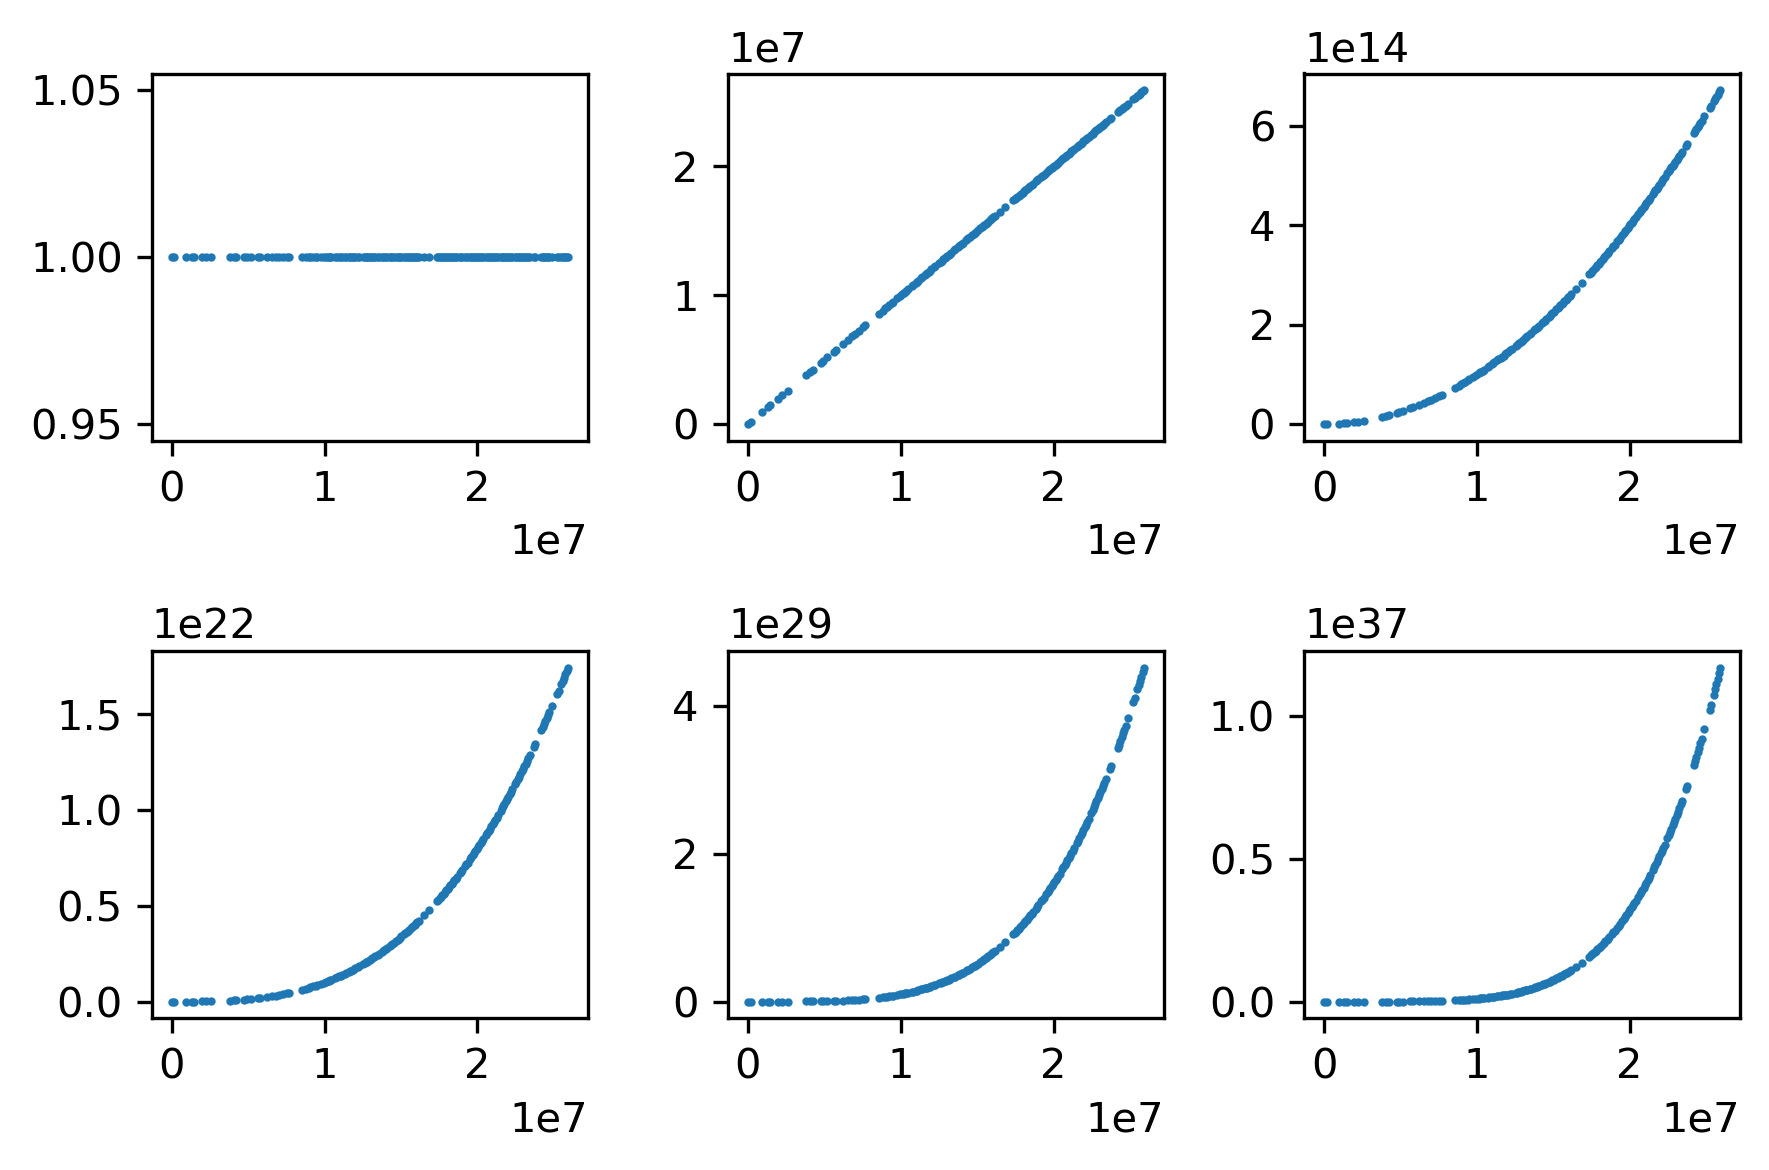

In [59]:
f = plt.figure(figsize=(6,4), dpi=300)
for p in range(6):
    plt.subplot(2,3,p+1)
    plt.scatter(np.asarray(df.datePOSIX).reshape((-1,1)), X_polynomial[:,p], s=1)
plt.tight_layout()

### оформим полиномиальную регрессию в виде класса, как и ранее - линейную

In [60]:
class polynomial_regression:
    def __init__(self, degree = 2):
        self.degree = degree
        self.theta = np.zeros((1,degree+1))
    
    def fit(self, X, y):
        X_train = np.asarray(X).reshape((-1, 1))
        transformer = PolynomialFeatures(degree=self.degree)
        X_polynomial = transformer.fit_transform(X_train)
        
        y_train = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_polynomial.T, X_polynomial)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_polynomial.T)
        theta_star = np.dot(m3, y_train)
        self.theta = theta_star
    
    def predict(self, X):
        X_test = np.asarray(X).reshape((-1, 1))
        transformer = PolynomialFeatures(degree=self.degree)
        X_polynomial = transformer.fit_transform(X_test)
        y_pred = np.dot(X_polynomial, self.theta)
        return y_pred

In [61]:
model_polynomial = polynomial_regression(degree=6)

In [62]:
model_polynomial.fit(df.datePOSIX, df.weight)

In [63]:
model_polynomial.theta

array([[ 8.03812036e+01],
       [-1.85490975e-06],
       [ 6.53796229e-13],
       [-9.27132666e-20],
       [ 6.18684374e-27],
       [-1.95318595e-34],
       [ 2.34767640e-42]])

In [68]:
y_test_approximated = model_polynomial.predict(x_lin_test)

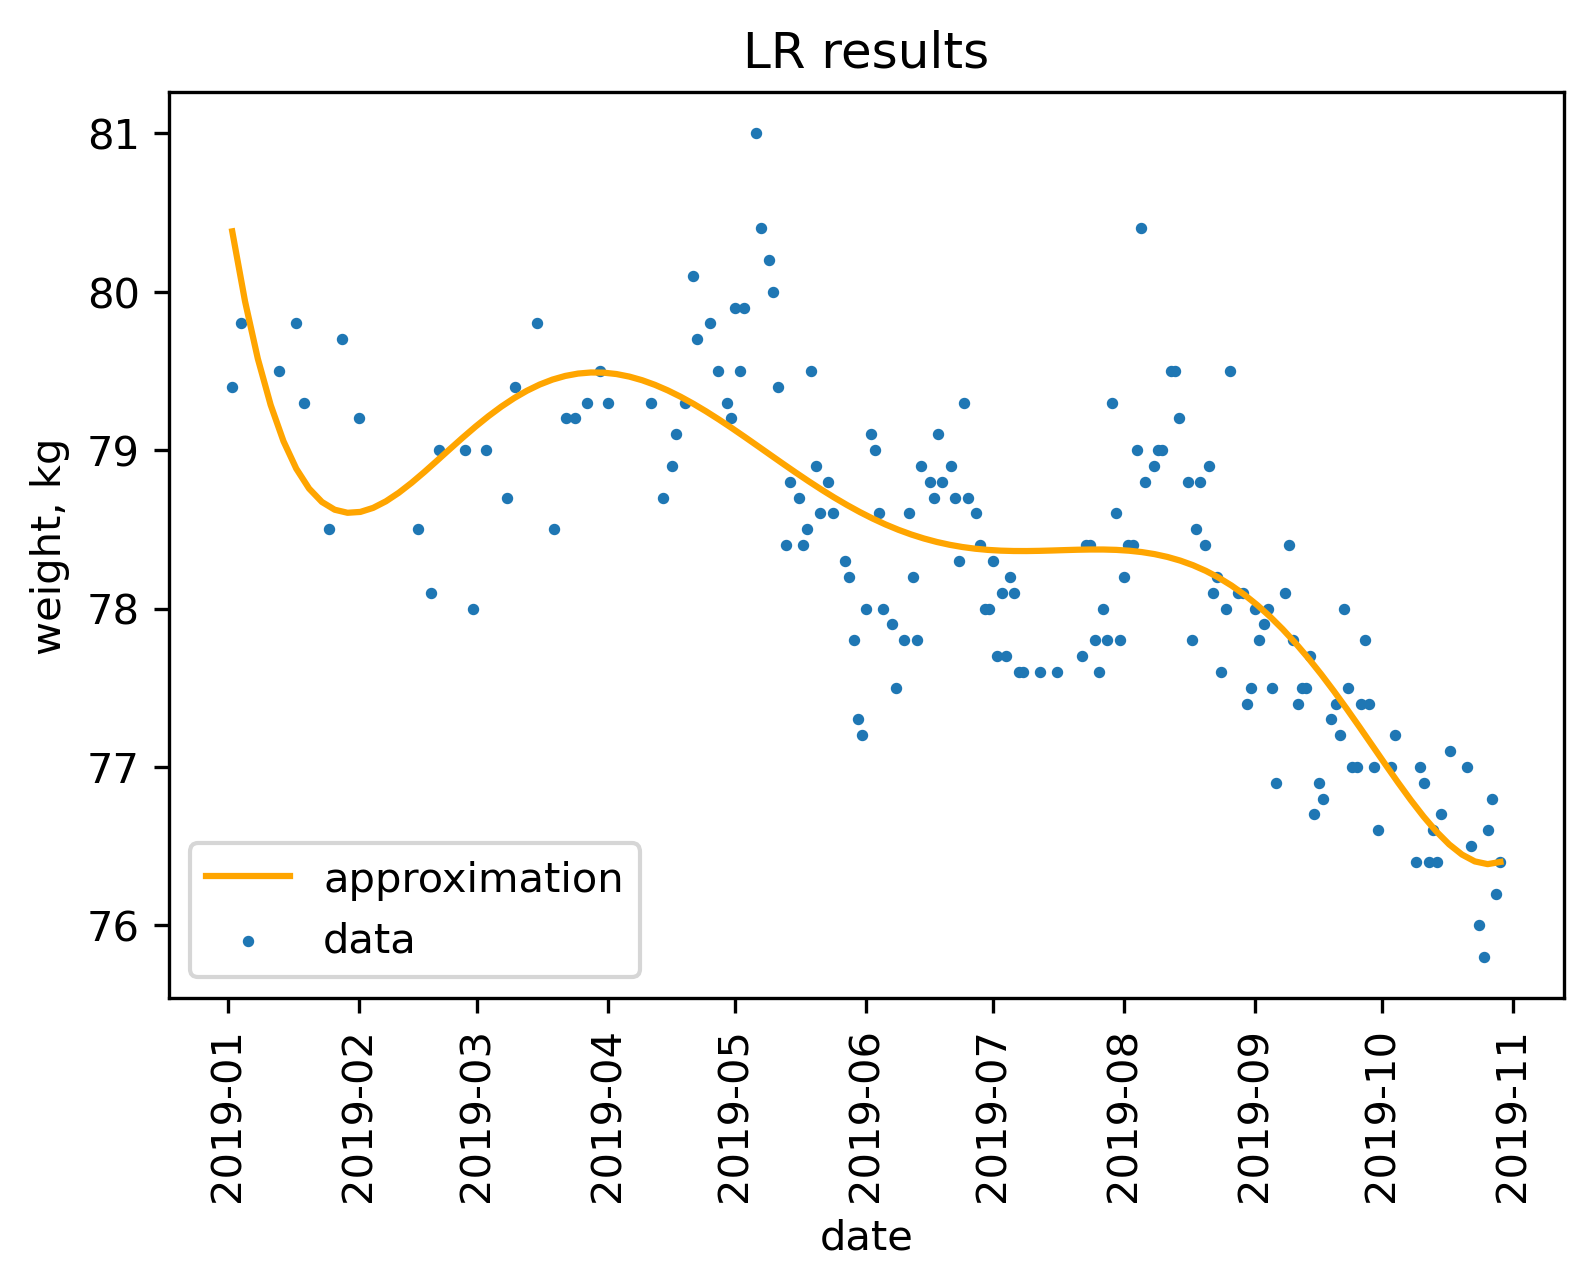

In [69]:
_ = plt.scatter(df.date, df.weight, s = 3, label='data')
_ = plt.plot(x_lin_test_datetimes, y_test_approximated, color='orange', label='approximation')
_ = plt.xticks(rotation=90)
_ = plt.legend()
_ = plt.title('LR results')
_ = plt.xlabel('date')
_ = plt.ylabel('weight, kg')

In [70]:
y_pred = model_polynomial.predict(df.datePOSIX)

In [71]:
RMSE(df.weight, y_pred)

0.5806177273318348

0.6 кг. среднеквадратичной ошибки - уже получше, чем в линейной модели. Может быть, можно еще лучше?

### Что если еще повысить степень полинома?
Посмотрим на среднеквадратичную ошибку при разных степенях полинома. Напомним, RMSE все еще оценивается неверно, но очень примерно дает представление об ошибке модели.

In [72]:
rmse_values = []
degrees = [d for d in range(10)]
for p in tqdm_notebook(degrees):
    model_polynomial = polynomial_regression(degree=p)
    model_polynomial.fit(df.datePOSIX, df.weight)
    y_pred = model_polynomial.predict(df.datePOSIX)
    rmse_values.append(RMSE(df.weight, y_pred))

Text(0, 0.5, 'RMSE, kg')

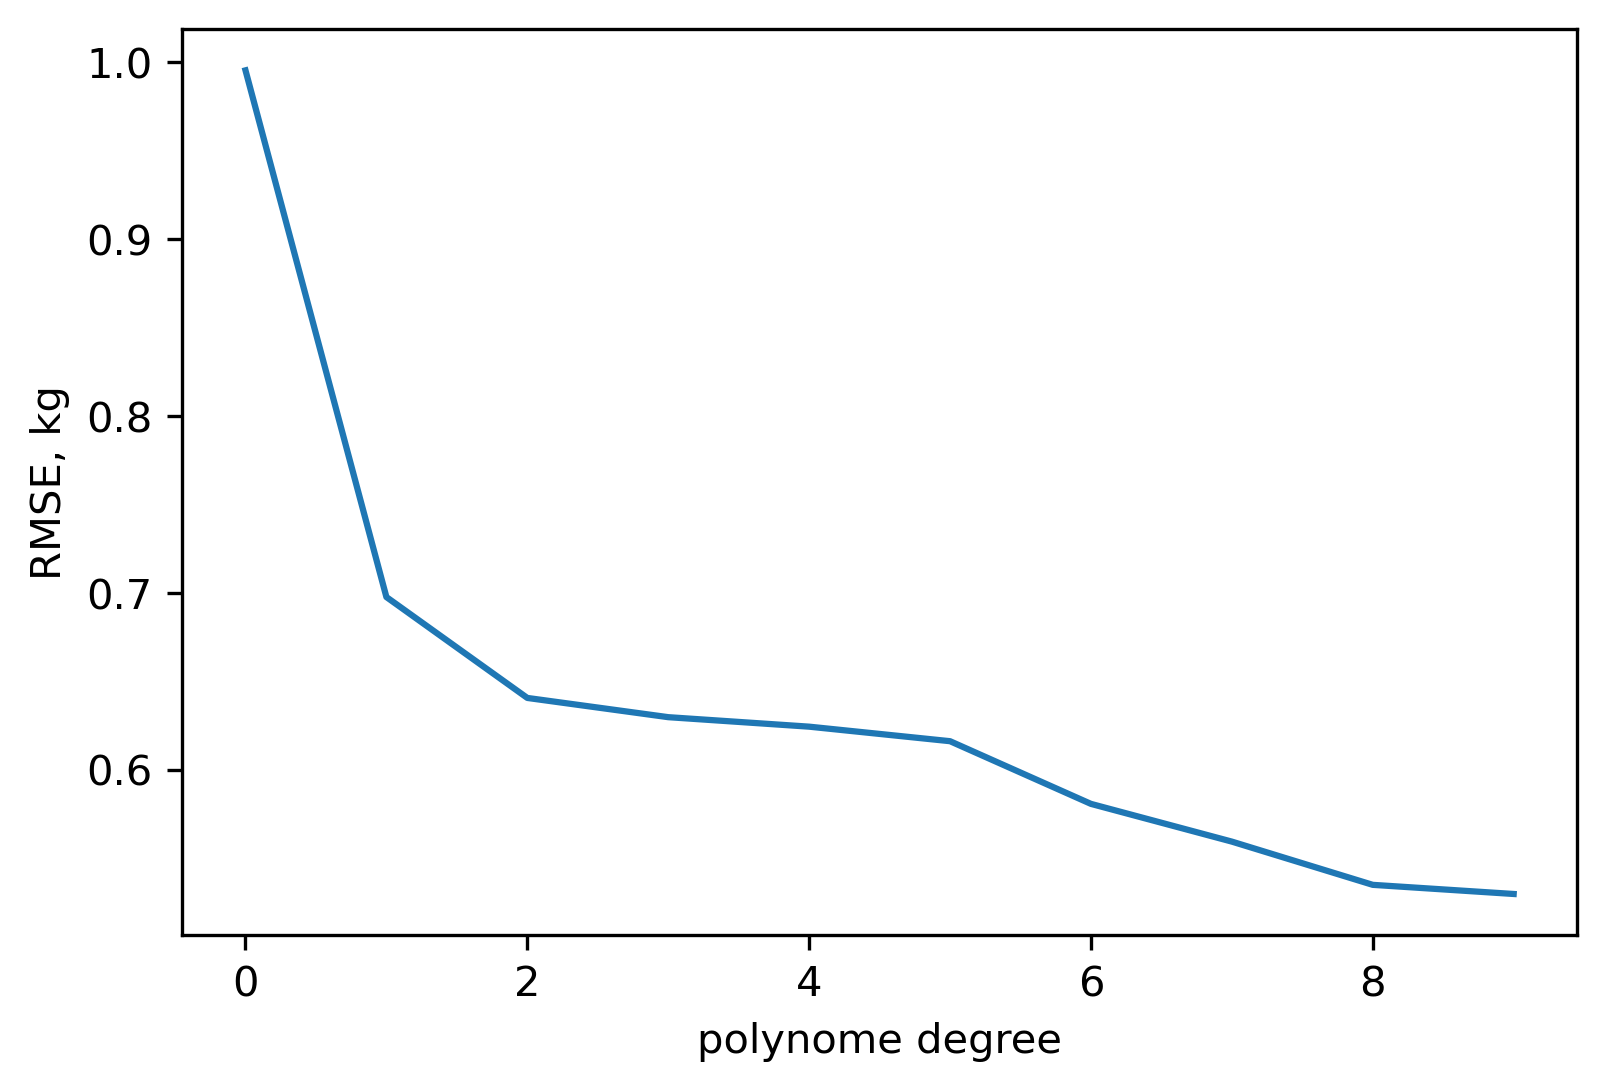

In [73]:
plt.plot(degrees, rmse_values)
plt.xlabel('polynome degree')
plt.ylabel('RMSE, kg')

С ростом степени полинома RMSE снижается.

### Так может быть и до нуля доберемся?

In [74]:
degrees = [d for d in range(25)]
rmse_values = []
for p in degrees:
    model_polynomial = polynomial_regression(degree=p)
    model_polynomial.fit(df.datePOSIX, df.weight)
    y_pred = model_polynomial.predict(df.datePOSIX)
    rmse_values.append(RMSE(df.weight, y_pred))
    print(p, '\t:\t', RMSE(df.weight, y_pred))

0 	:	 0.9955164796348125
1 	:	 0.6975976673459893
2 	:	 0.6405405391023724
3 	:	 0.6296606638473882
4 	:	 0.6242910635465595
5 	:	 0.6160725241661889
6 	:	 0.5806177273318348
7 	:	 0.5592764348743283
8 	:	 0.5348203627194161
9 	:	 0.5296495932106536
10 	:	 0.5916205280291579
11 	:	 3.3386939585561426
12 	:	 637.033194931483
13 	:	 629.8946928612626
14 	:	 726.3436944471079
15 	:	 171.6173819423037
16 	:	 1069.3252967574715
17 	:	 1442.4350890973906
18 	:	 1837.640084516001
19 	:	 8786.407438676728
20 	:	 1228.7150630667497
21 	:	 nan
22 	:	 nan
23 	:	 nan
24 	:	 nan


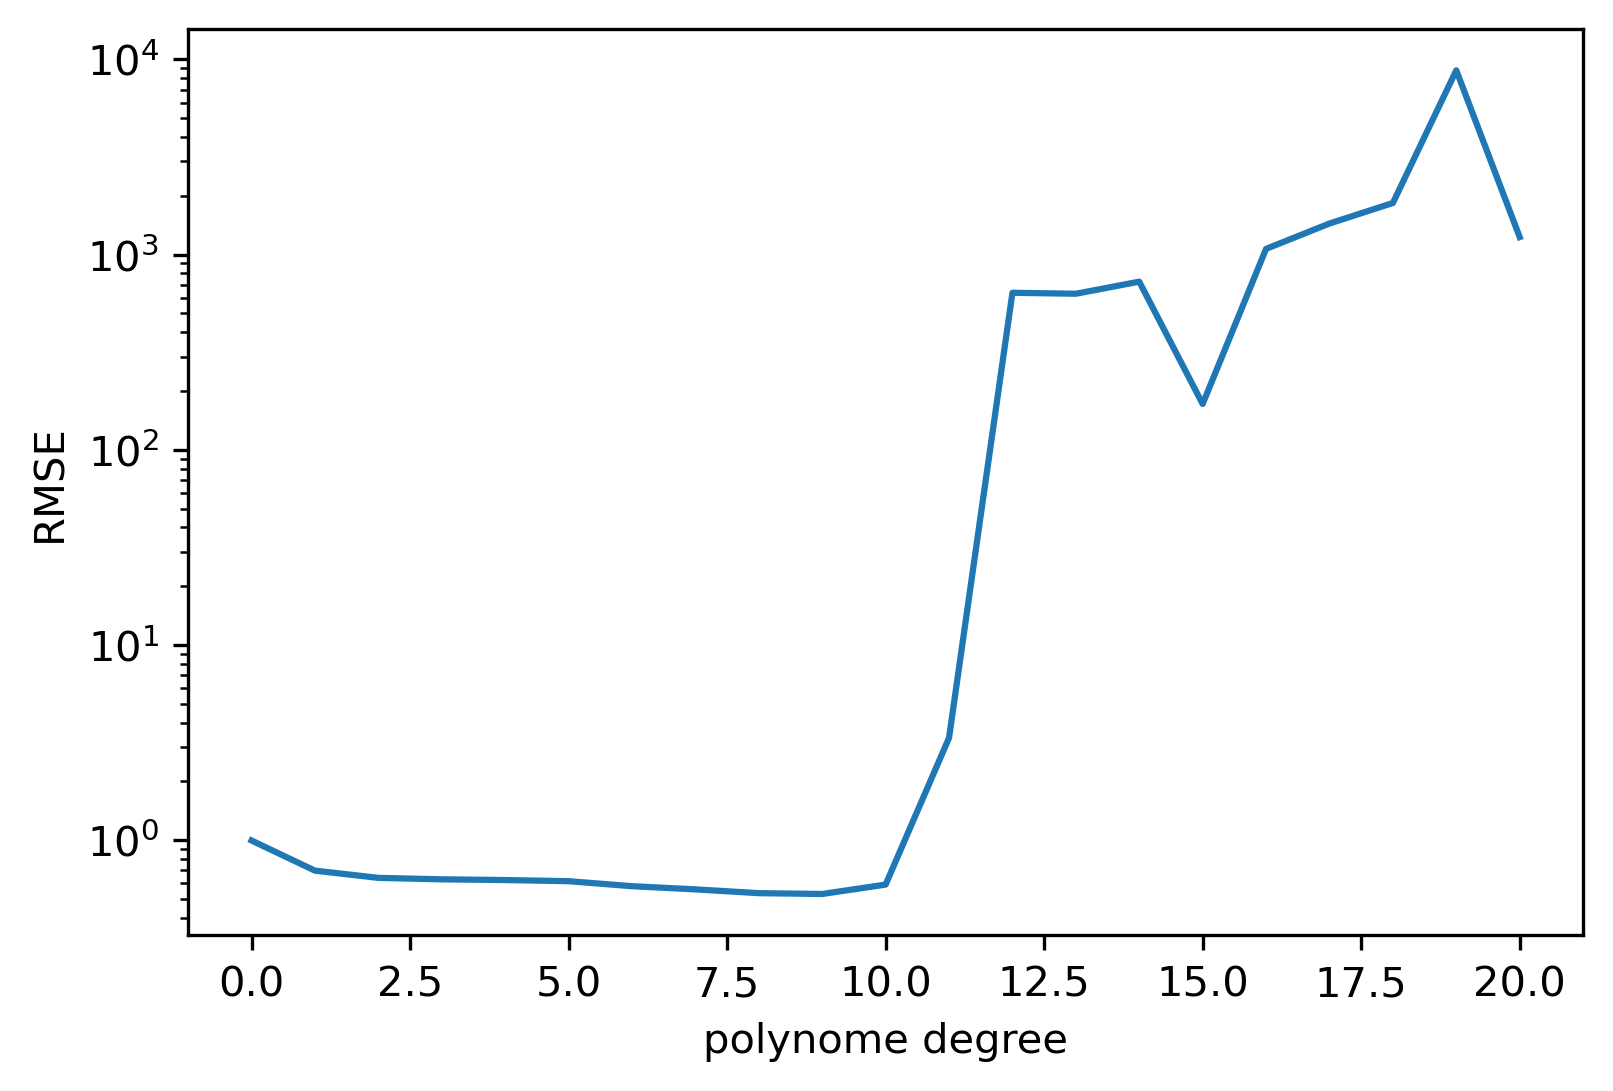

In [75]:
plt.plot(degrees, rmse_values)
plt.yscale('log')
plt.ylabel('RMSE')
_ = plt.xlabel('polynome degree')

## упс...

### OK, но вроде степень 9 дает лучшее качество...

In [77]:
model_polynomial = polynomial_regression(degree=9)
model_polynomial.fit(df.datePOSIX, df.weight)
x_to_predict = datetime.datetime(2021,11,9,12,0,0).timestamp() - min_date
y_predicted = model_polynomial.predict(x_to_predict)
print('вес на 09.11.2021: %.1f кг.' % y_predicted)

вес на 09.11.2021: -330555857.3 кг.


## упс... снова.

## Что будет, если обучающих данных мало?

In [110]:
rand_perm_indices = np.random.permutation(df.datePOSIX.shape[0])
indices_subset = rand_perm_indices[:5]
rest_indices = rand_perm_indices[5:]

In [111]:
X_subset = np.asarray(df.datePOSIX)[indices_subset]
X_subset_datetimes = df.date[indices_subset]

In [112]:
y_subset = np.asarray(df.weight)[indices_subset]

In [121]:
model_polynomial = polynomial_regression(degree=9)
model_polynomial.fit(X_subset, y_subset)

In [122]:
y_approximated_linspace = model_polynomial.predict(x_lin_test)

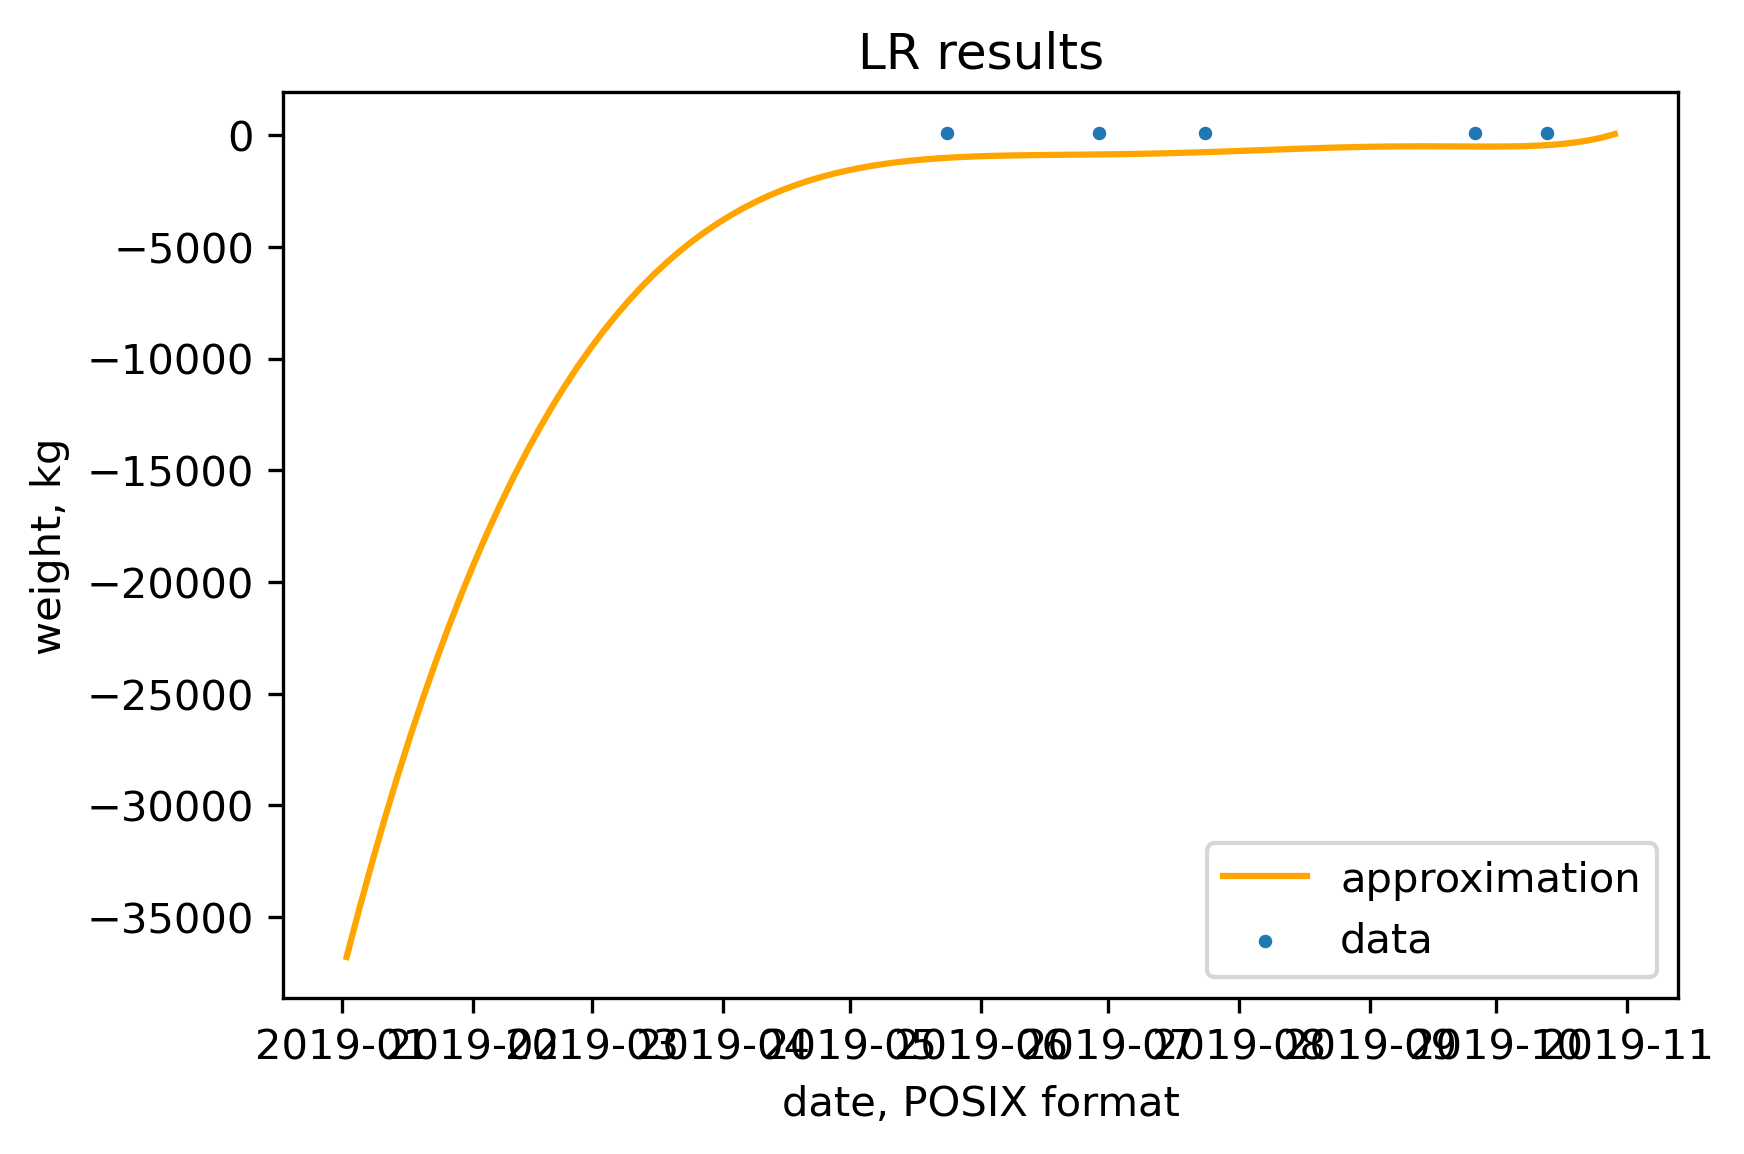

In [123]:
_ = plt.scatter(X_subset_datetimes, y_subset, s = 5, label='data')
_ = plt.plot(x_lin_test_datetimes, y_approximated_linspace, color='orange', label='approximation', zorder = 0)
_ = plt.legend()
_ = plt.title('LR results')
_ = plt.xlabel('date, POSIX format')
_ = plt.ylabel('weight, kg')

## Посчитаем аппроксимацию целевой переменной на "новых" примерах

In [124]:
X_rest = np.asarray(df.datePOSIX)[rest_indices]
y_rest = np.asarray(df.weight)[rest_indices]

In [125]:
y_rest_pred = model_polynomial.predict(X_rest)

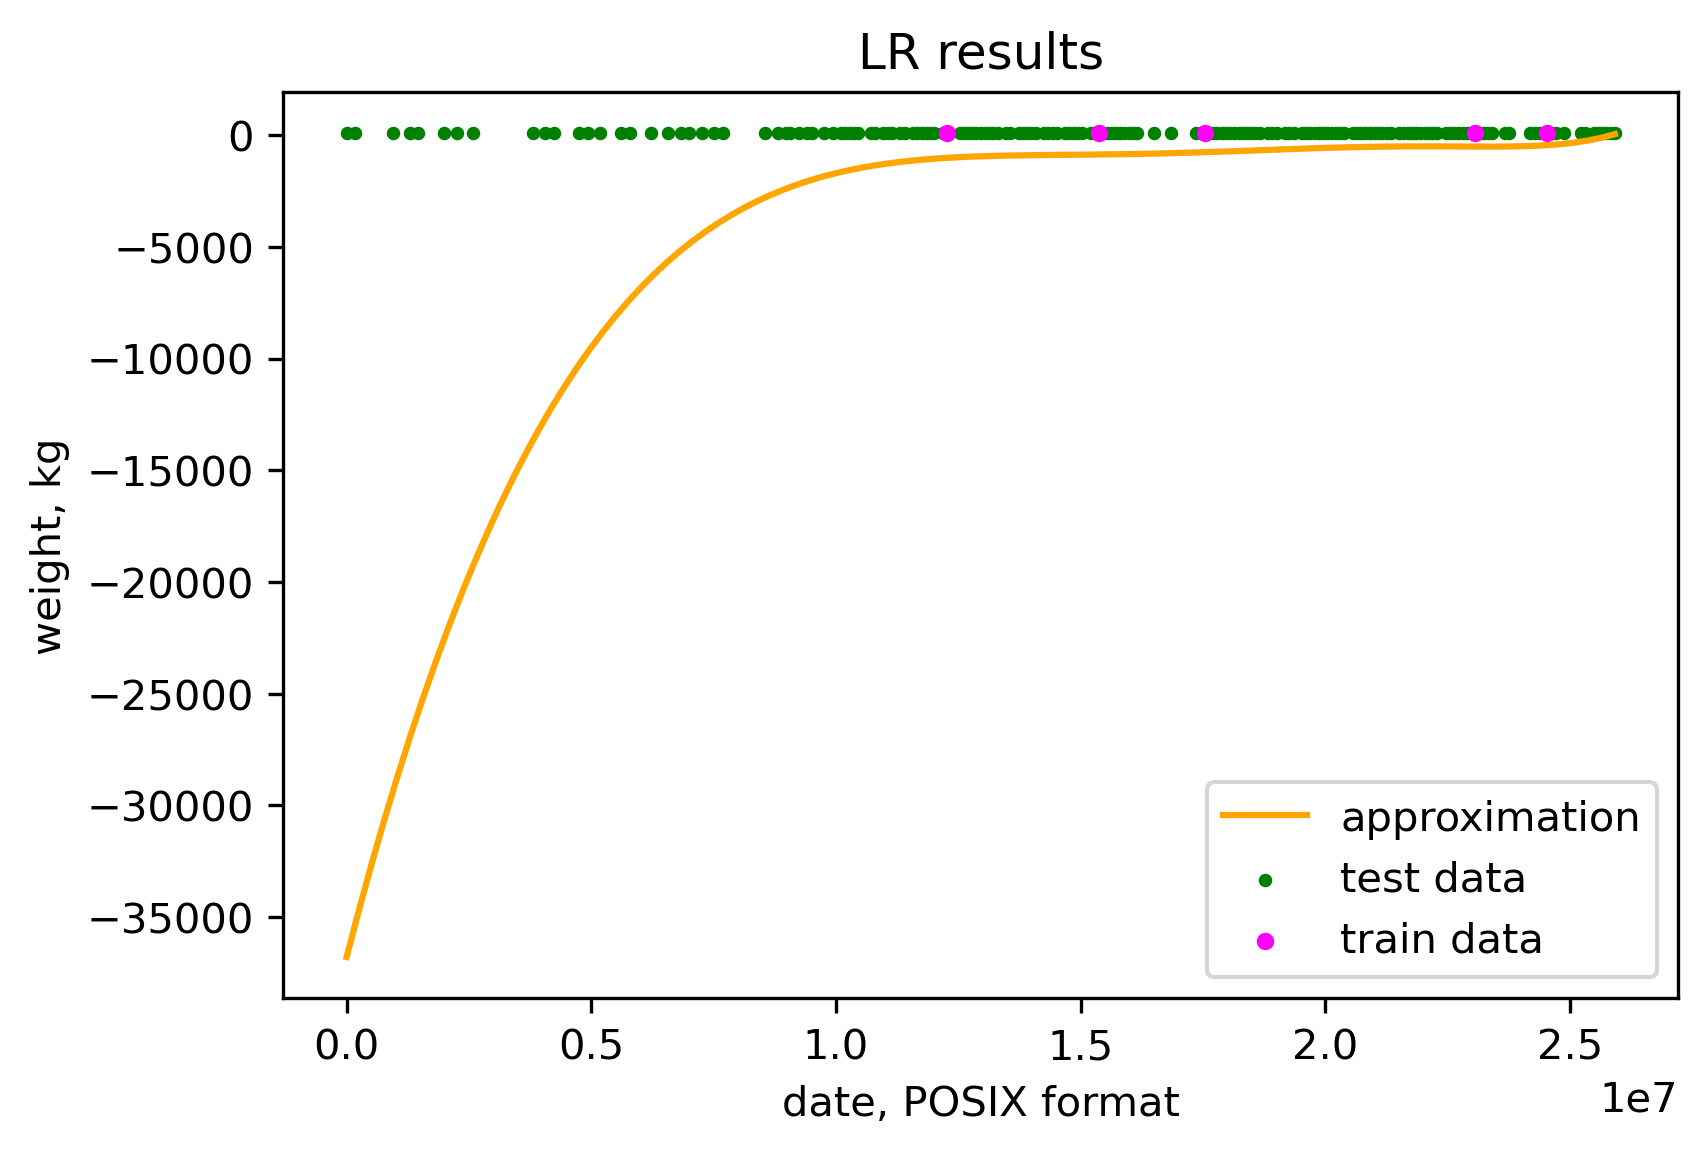

In [126]:
_ = plt.plot(x_lin_test, y_approximated_linspace, color='orange', label='approximation')
_ = plt.scatter(X_rest, y_rest, s = 5, label='test data', color='green')
_ = plt.scatter(X_subset, y_subset, s = 10, label='train data', color='magenta')
_ = plt.legend()
_ = plt.title('LR results')
_ = plt.xlabel('date, POSIX format')
_ = plt.ylabel('weight, kg')

In [127]:
RMSE(y_subset, model_polynomial.predict(X_subset))

826.6151954225419

In [128]:
RMSE(y_rest, y_rest_pred)

6616.8468172025805

## ВЫВОДЫ?

- Нельзя оценивать качество модели на той же выборке, на которой она обучалась - это недостоверная оценка
- Качество следует оценивать на выборке, которая не была представлена модели на момент обучения - т.н. `тестовой выборке`
- Если модель обладает достаточной выразительной способностью, а обучающая выборка невелика, - в подходе оценки по `методу максимального правдоподобия (Maximum Likelihood Estimation)` легко столкнуться с явлением `переобучения (overfitting)`

## Переобучение:
(Нежелательное) явление, при котором качество модели, оцениваемое на тренировочной выборке, сильно отличается в лучшую сторону от качества на вновь поступающих примерах.

Нередко бывает, что переобучение обусловлено неверным соотношением выразительной способности модели и количества обучающих данных: модель выбрана слишком "сильная", в процессе обучения способна усвоить структуру данных.

## Недообучение
Альтернативное (нежелательное) поведение модели.

Явление, при котором качество модели, оцениваемое на тренировочной выборке и на вновь поступающих примерах сравнительно невелико и отличается не сильно.

Характерной ситуацией, в которой может наблюдаться недообучение, является выбор слишком слабой модели, неспособной описать все особенности данных тренировочной выборки. В этом случае говорят, что выразительная способность модели низка.

## Обобщающая способность

-- свойство модели выдавать правильный ответ или ответ, достаточно близкий к правильному, не только для примеров тренировочной выборки (продемонстрированных во время обучения), но и на любых новых примерах. При этом подразумевается, что новые примеры подчиняются закономерности, которой подчиняются примеры тренировочной выборки.

Способность модели к обобщению - важнейшее свойство, без которого эксплуатация модели в большинстве случаев лишена смысла.

Проверка обобщающей способности заключается в сопоставлении качества модели на `тренировочной (обучающей) выборке` и на новых примерах - `тестовой выборке`.

### Так что же было неверно в оценке RMSE?

-- Оценка проводилась каждый раз на той же выборке, на которой была оптимизирована модель. Это грубейшая ошибка, приводящая к недостоверной оценке ошибок модели, которые она может допустить на новых данных. 

# Далее:

Оценка качества модели во время обучения и после оптимизации. Бутстрэп (bootstrap), скользящий контроль (cross-validation). Тренировочная, тестовая и валидационные выборки.